In [ ]:
import os
import zipfile
import numpy as np
import torch
import torch.nn as nn


import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

!gdown 1GUI8x3Hxze1nqb1-Ban-tDtdfyLSSAhM

Downloading...
From: https://drive.google.com/uc?id=1GUI8x3Hxze1nqb1-Ban-tDtdfyLSSAhM
To: /content/Img_file.zip
100% 15.2M/15.2M [00:00<00:00, 148MB/s]


In [ ]:
#import training set
FILE_PATH = '/content/extracted_files'
with zipfile.ZipFile('/content/Img_file.zip', 'r') as ref:
  ref.extractall(FILE_PATH)
Categories = [os.listdir("/content/extracted_files/Img_file/" + str(i)) for i in range(8)]


In [ ]:
#create training and testing set
from sklearn.model_selection import train_test_split
S = []
for i in range(len(Categories)):
  for f in Categories[i]:
    path = os.path.join("/content/extracted_files/Img_file/"+str(i),f)
    S.append((path,i))

X = [each[0] for each in S]
y = [each[1] for each in S]
train_X,test_X,train_y,test_y = train_test_split(X, y, test_size=0.2)

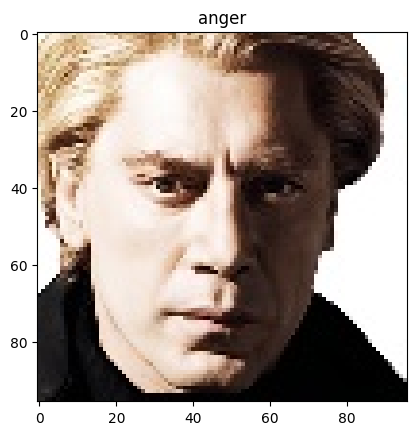

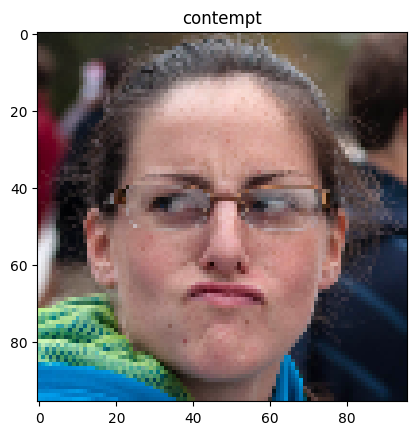

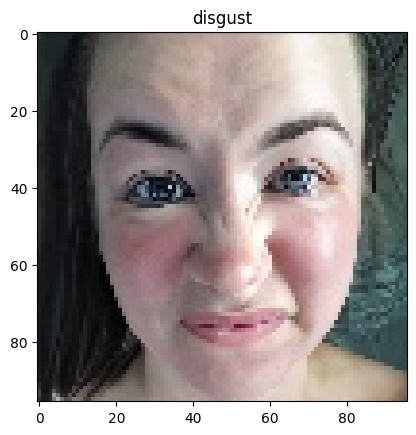

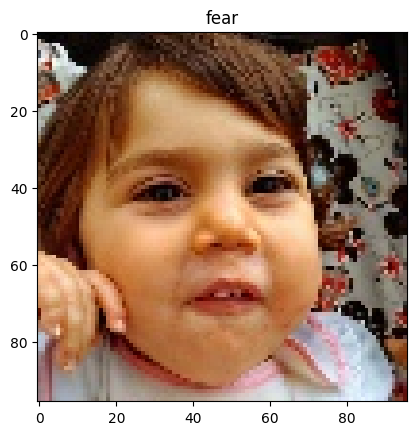

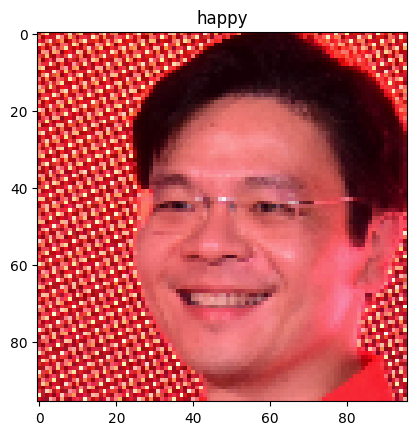

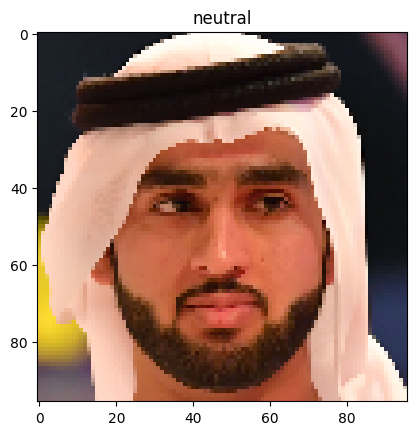

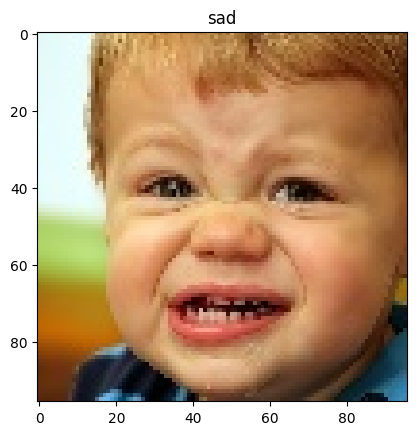

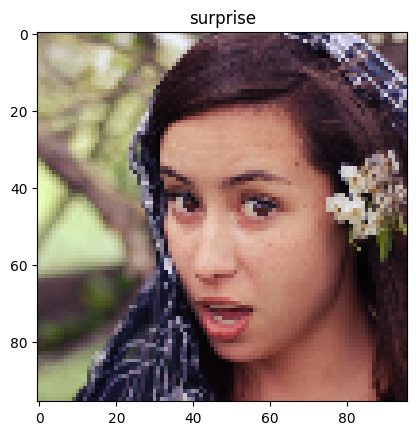

In [ ]:
#sample display
CLASSNAME_8_LABEL = {0: "anger", 1: "contempt", 2: "disgust", 3: "fear", 4: "happy", 5: "neutral", 6: "sad", 7: "surprise"}

for i in range(len(Categories)):
  for f in Categories[i]:
    path = os.path.join("/content/extracted_files/Img_file/"+str(i),f)
    image = Image.open(path)
    label = CLASSNAME_8_LABEL[i]
    plt.title(label, fontsize=12)
    plt.imshow(image)
    plt.show()
    break



In [ ]:
SIZE = 224 #dataset code
class emotionDmgDataset(Dataset):
  def __init__(self,split,size = SIZE):
     #super().__init__()
     self.size = size
     self.split = split

  def __len__(self):
    return int(0.2 * 800) if self.split == 'test' else int(0.8 * 800)

  def __getitem__(self,idx):
    if self.split == "train":
      img_path = train_X[idx]
      label = train_y[idx]
    else:
      img_path = test_X[idx]
      label = test_y[idx]
    img = Image.open(img_path)

    allTransforms = transforms.Compose([
            transforms.Resize(size  = (self.size, self.size)),
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
        ])
    img = allTransforms(img)
    img = torch.FloatTensor(img)
    return img, label

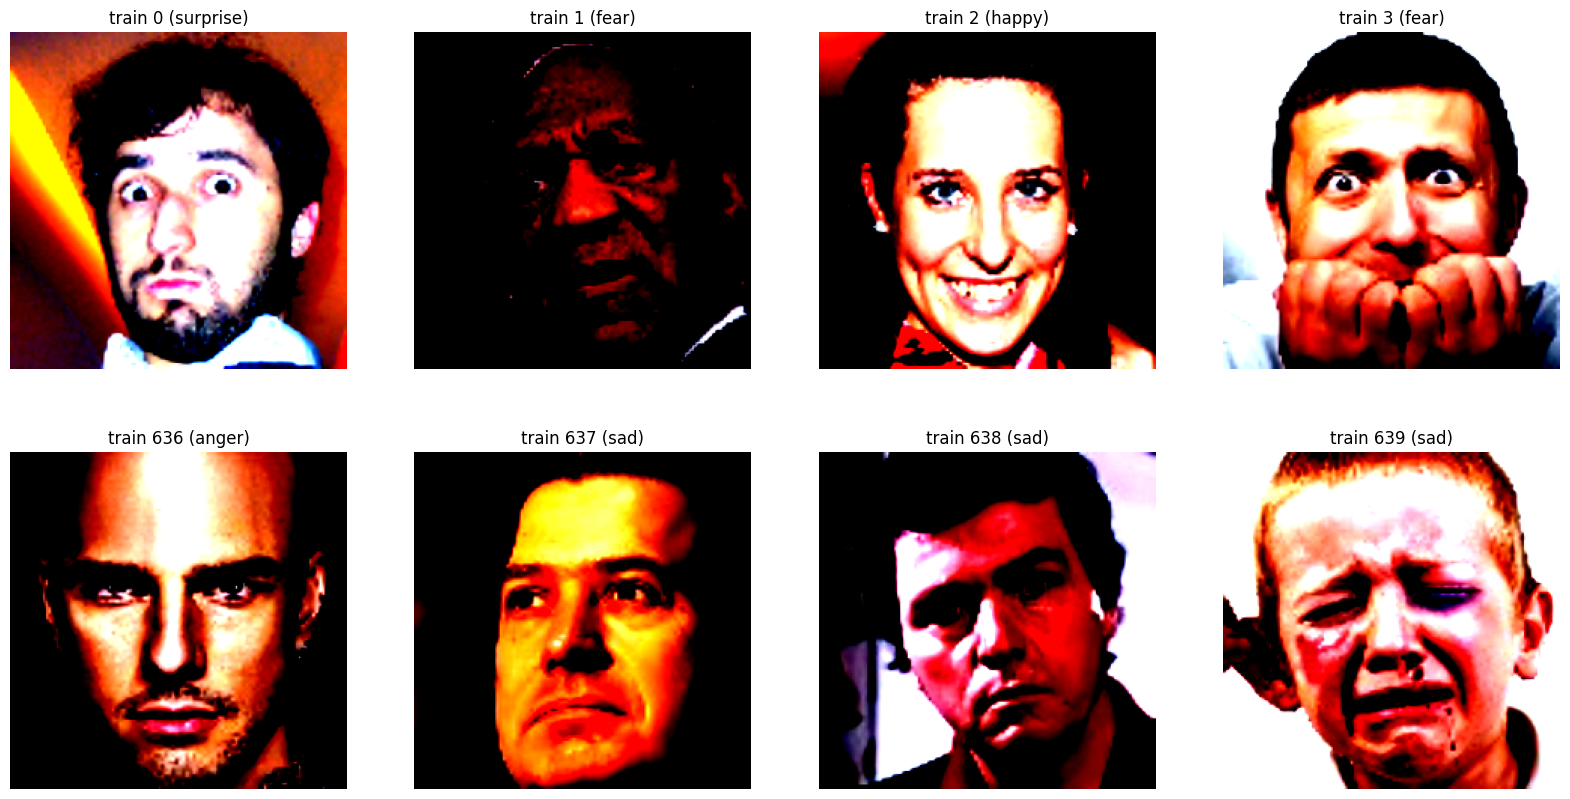

In [ ]:
train_dataset = emotionDmgDataset(split = "train")
test_dataset = emotionDmgDataset(split = "test")

indices = list(range(4)) + list(range(len(train_dataset)-4, len(train_dataset)))
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes_flat = axes.flatten()

for i, id in enumerate(indices):

    (image, label) = train_dataset[id]
    image = torch.clip(image, min = 0, max = 1)
    image = image.permute(1, 2, 0)

    label_str = CLASSNAME_8_LABEL[label]
    axes_flat[i].imshow(image)
    axes_flat[i].set_title(f'train {id} ({label_str})')
    axes_flat[i].axis('off')


plt.show()




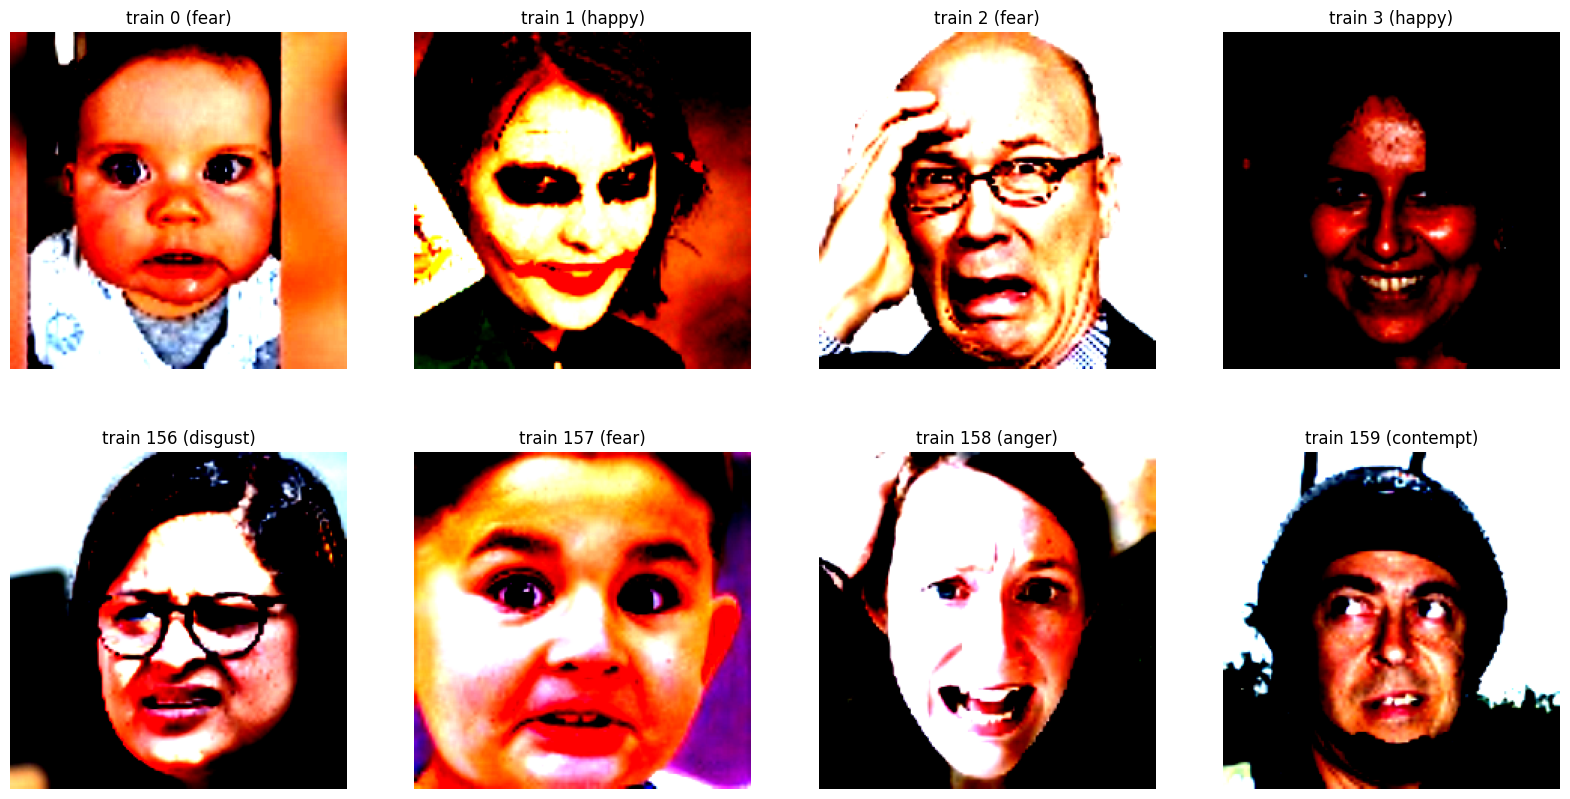

In [ ]:
indices = list(range(4)) + list(range(len(test_dataset)-4, len(test_dataset)))
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes_flat = axes.flatten()

for i, id in enumerate(indices):

    (image, label) = test_dataset[id]
    image = torch.clip(image, min = 0, max = 1)
    image = image.permute(1, 2, 0)

    label_str = CLASSNAME_8_LABEL[label]
    axes_flat[i].imshow(image)
    axes_flat[i].set_title(f'train {id} ({label_str})')
    axes_flat[i].axis('off')


plt.show()

In [ ]:
# [AG] defining the datasets, data-loaders, loss functions, and optimizers
def createTrainingUtils(model):
    trainDL, testDL, lossfn, opt = None, None, None, None

    trainDL = DataLoader(emotionDmgDataset("train"), batch_size = 16, shuffle = True)
    testDL = DataLoader(emotionDmgDataset("test"), batch_size = 16, shuffle = True)
    lossfn = nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters(), lr = 0.001)

    return trainDL, testDL, lossfn, opt

In [ ]:
class FCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # self.linear1 = nn.Linear(in_features = SIZE * SIZE * 3, out_features = SIZE * 3, bias = True)
        # self.activation1 = nn.ReLU()
        # self.linear2 = nn.Linear(in_features = SIZE * 3, out_features = 8, bias = True)
        # self.activation2 = nn.Softmax(dim = 1)
        self.mobilenet = None
        self.finalActivation = None
        self.mobilenet = torchvision.models.mobilenet_v2(weights=pretrained, progress=False)
        self.mobilenet.classifier[1] = nn.Linear(in_features=1280, out_features=1, bias=True)

        self.finalActivation = nn.Sigmoid()
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        y_hat = self.activation2(x)
        return y_hat




In [ ]:

def one_hot_h(x):
    res = np.zeros(8)
    res[x] = 1
    return res

def one_hot(y):
    res = []
    for i in range(len(y)):
      res.append(one_hot_h(y[i]))
    return torch.tensor(res, dtype = float)

In [ ]:
one_hot([1,2])

tensor([[0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.]], dtype=torch.float64)

In [ ]:
class CNN(nn.Module):
    def __init__(self):

        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 36, kernel_size = 2, padding = 1)
        # self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels = 36, out_channels = 36, kernel_size = 2, padding = 1)
        self.conv3 = nn.Conv2d(in_channels = 36, out_channels = 36, kernel_size = 2, padding = 1)
        self.conv4 = nn.Conv2d(in_channels = 36, out_channels = 36, kernel_size = 2, padding = 1)
        self.conv5 = nn.Conv2d(in_channels = 36, out_channels = 36, kernel_size = 2, padding = 1)
        self.conv6 = nn.Conv2d(in_channels = 36, out_channels = 36, kernel_size = 2, padding = 1)
        self.conv7 = nn.Conv2d(in_channels = 36, out_channels = 36, kernel_size = 2, padding = 1)
        self.linear = nn.Linear(in_features = 1920996, out_features = 8, bias = True)
        self.activation = nn.Softmax()
    def forward(self, x):
        x = self.conv1(x)
        # x = self.pool(x)
        x = self.conv2(x)
        # x = self.pool(x)
        x = self.conv3(x)
        # x = self.pool(x)
        x = self.conv4(x)
        # x = self.pool(x)
        x = self.conv5(x)
        # x = self.pool(x)
        x = self.conv6(x)
        # x = self.pool(x)
        x = self.conv7(x)
        # x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        y_hat = self.activation(x)
        return y_hat

In [ ]:
def evalDL(model, dl, lossfn):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    with torch.no_grad():
        lossSum = 0
        nCorrect = 0
        for x, y in dl:
            y = one_hot(y)
            x = x.to(device)
            y = y.to(device)
            yhat = model(x)
            print("yhat is",yhat,yhat.shape)
            print("y is",y,y.shape)
            lossSum += lossfn(yhat, y) * x.shape[0]
            for i in range(len(y)):
              pred = yhat[i]
              val = y[i]
              if torch.argmax(pred) == torch.argmax(val):
                nCorrect += 1



        numSamples = len(dl.dataset)
        avgLoss = lossSum / numSamples
        acc = nCorrect / numSamples
    return avgLoss.item(),acc

def evaluate(model, trainDL, validDL, lossfn):
    trainLoss, trainAcc = evalDL(model, trainDL, lossfn)
    validLoss, validAcc = evalDL(model, validDL, lossfn)
    return trainLoss, trainAcc, validLoss, validAcc

In [ ]:

def train(model, trainDL, validDL, lossfn, opt, epochs=10):


    trainLosses = []
    trainAccs   = []
    validLosses = []
    validAccs   = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    trainLoss, trainAcc, validLoss, validAcc = evaluate(model, trainDL, validDL, lossfn)
    trainLosses.append(trainLoss)
    trainAccs.append(trainAcc)
    validLosses.append(validLoss)
    validAccs.append(validAcc)
    print(f"Initial Model: train-loss={trainLoss:<4.2f} train-acc={trainAcc:<4.2f} valid-loss={validLoss:<4.2f} valid-acc={validAcc:<4.2f}")

    model.to(device)

    for e in range(epochs):
        for X, y in trainDL:

            y = one_hot(y)

            X, y = X.to(device), y.to(device)
            opt.zero_grad()
            y_hat = model.forward(X)

            loss = lossfn(y_hat, y)
            loss.backward()
            opt.step()
            print(f"epoch: {e}, loss = {loss}")




        trainLoss, trainAcc, validLoss, validAcc = evaluate(model, trainDL, validDL, lossfn)
        trainLosses.append(trainLoss)
        trainAccs.append(trainAcc)
        validLosses.append(validLoss)
        validAccs.append(validAcc)
        print(f"Epoch {e:>4d}: train-loss={trainLoss:<4.2f} train-acc={trainAcc:<4.2f} valid-loss={validLoss:<4.2f} valid-acc={validAcc:<4.2f}")

    return model, trainLosses, trainAccs, validLosses, validAccs

In [ ]:
def plotStatistics(epochs, trainLosses, trainAccs, validLosses, validAccs):
    fig, axes = plt.subplots(1,2)
    xdata = np.arange(epochs+1)
    fig.subplots_adjust(wspace=0.4)

    # plot the losses
    axis = axes[0]
    axis.plot(xdata, trainLosses, label="Train")
    axis.plot(xdata, validLosses, label="Valid")
    axis.set_xlabel("# Epochs")
    axis.set_ylabel("Average Loss")
    axis.grid()
    axis.legend()

    # plot the accuracies
    axis = axes[1]
    axis.plot(xdata, trainAccs, label="Train")
    axis.plot(xdata, validAccs, label="Valid")
    axis.set_xlabel("# Epochs")
    axis.set_ylabel("Accuracy")
    axis.grid()
    axis.legend()

In [ ]:
import torchvision.models as models
modelf = models.mobilenet_v2(pretrained=False)

class HotdogMobileNet(nn.Module):
    def __init__(self, pretrained=False):
        '''Initializer for the MobileNet model to predict on the HotdogDataset

        1. load the mobilenet_v2 model (you will have to load weights depending on input pretrained)
        2. modify the final linear layer of the classifier to output 1 unit
        3. create a new final activation layer to turn the single output of the modified Mobilenet into a probability
            - we do this because MobileNet itself doesn't have any final activation layer
            - you will have to choose the appropriate activation for this last part

        Note: when loading the mobilenet model, set progress=False to avoid messing up the autograder

        Arguments:
            - pretrained: boolean indicating whether to use pre-trained weights on ImageNet (weights="MobileNet_V2_Weights.IMAGENET1K_V1")
                          or random weights but still using the model architecture (weights=None)
        '''
        super().__init__()
        self.mobilenet = None
        self.finalActivation = None
        self.mobilenet = torchvision.models.mobilenet_v2(weights=pretrained, progress=False)
        self.mobilenet.classifier[1] = nn.Linear(in_features=1280, out_features=1, bias=True)

        self.finalActivation = nn.Sigmoid()


    def forward(self, x):
        x = self.mobilenet(x)
        yhat = self.finalActivation(x)
        return yhat

In [ ]:


def trainAndPlot():
    model = modelf
    trainDL, validDL, lossfn, opt = createTrainingUtils(model)
    model, trainLosses, trainAccs, validLosses, validAccs = train(model, trainDL, validDL, lossfn, opt, epochs=10)
    plotStatistics(10, trainLosses, trainAccs, validLosses, validAccs)

    return model


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


prediction is tensor(2)
truth tensor(118)
prediction is tensor(3)
truth tensor(118)
prediction is tensor(0)
truth tensor(94)
prediction is tensor(3)
truth tensor(22)
prediction is tensor(3)
truth tensor(70)
prediction is tensor(4)
truth tensor(112)
prediction is tensor(1)
truth tensor(30)
prediction is tensor(5)
truth tensor(6)
prediction is tensor(5)
truth tensor(78)
prediction is tensor(3)
truth tensor(112)
prediction is tensor(5)
truth tensor(38)
prediction is tensor(2)
truth tensor(30)
prediction is tensor(5)
truth tensor(6)
prediction is tensor(6)
truth tensor(30)
prediction is tensor(6)
truth tensor(46)
prediction is tensor(5)
truth tensor(14)
prediction is tensor(1)
truth tensor(102)
prediction is tensor(4)
truth tensor(22)
prediction is tensor(0)
truth tensor(110)
prediction is tensor(7)
truth tensor(46)
prediction is tensor(4)
truth tensor(46)
prediction is tensor(4)
truth tensor(38)
prediction is tensor(7)
truth tensor(46)
prediction is tensor(7)
truth tensor(6)
prediction is

CNN(
  (conv1): Conv2d(3, 36, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(36, 36, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(36, 36, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(36, 36, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(36, 36, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(36, 36, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(36, 36, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (linear): Linear(in_features=1920996, out_features=8, bias=True)
  (activation): Softmax(dim=None)
)

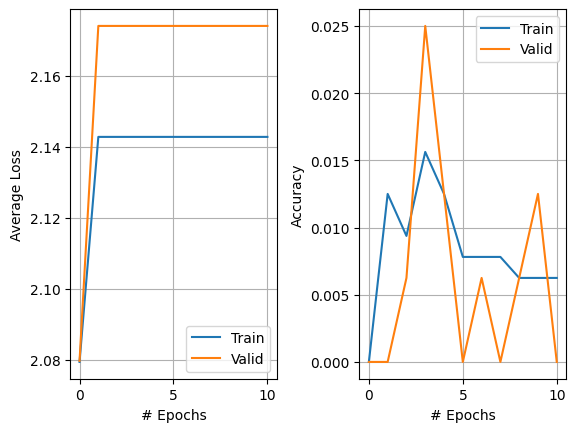

In [ ]:
trainAndPlot()